In [5]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from datasets import load_metric, Dataset as HFDataset, DatasetDict, Features, ClassLabel, Array3D
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [6]:
#  Define Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.dataset = datasets.ImageFolder(img_dir, transform=transform)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {"pixel_values": image, "label": label}
    
    def get_classes(self):
        return self.dataset.classes

# Define dataset paths
train_dir = 'fruit30_split/train'
val_dir = 'fruit30_split/val'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load custom datasets with transformations
train_dataset = CustomImageDataset(train_dir, transform)
test_dataset = CustomImageDataset(val_dir, transform)

# Split the original training dataset into new training and validation sets (9:1 ratio)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
new_train_dataset, new_val_dataset = random_split(train_dataset, [train_size, val_size])


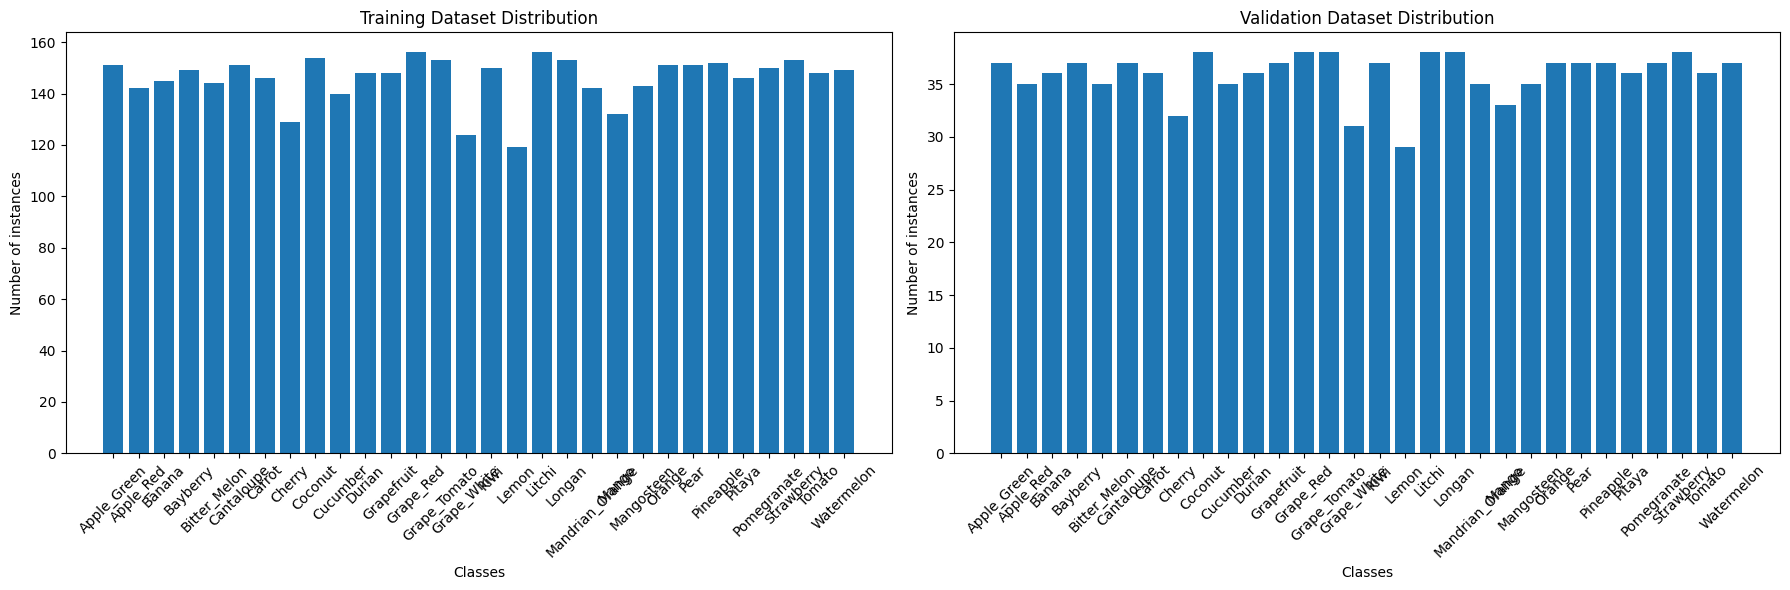

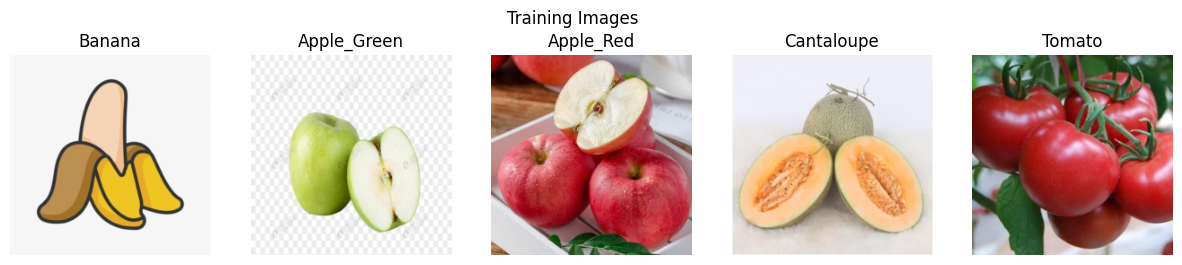

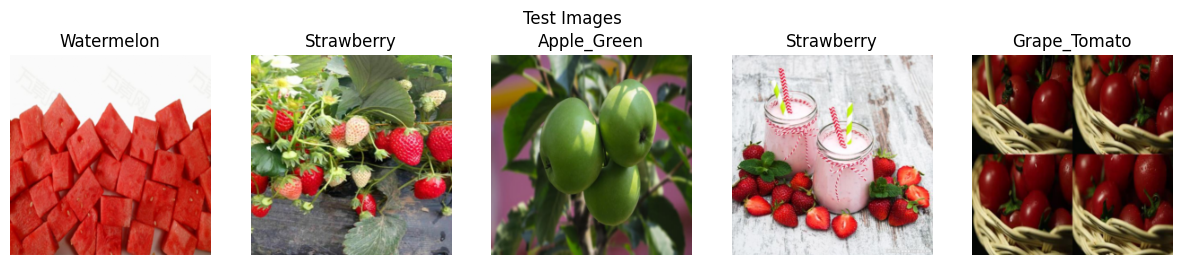

In [7]:
# Function to visualize the number of instances for different classes
def visualize_class_distribution(train_dataset, val_dataset):
    train_class_counts = {class_name: len(os.listdir(os.path.join(train_dataset.img_dir, class_name))) for class_name in os.listdir(train_dataset.img_dir)}
    val_class_counts = {class_name: len(os.listdir(os.path.join(val_dataset.img_dir, class_name))) for class_name in os.listdir(val_dataset.img_dir)}
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    ax1.bar(train_class_counts.keys(), train_class_counts.values())
    ax1.set_title('Training Dataset Distribution')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Number of instances')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2.bar(val_class_counts.keys(), val_class_counts.values())
    ax2.set_title('Validation Dataset Distribution')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Number of instances')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualize class distributions
visualize_class_distribution(train_dataset, test_dataset)



# Display some training and validation images with their labels
def show_images(dataset, title, num_images=5):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    batch = next(iter(loader))
    images = batch["pixel_values"]
    labels = batch["label"]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(dataset.dataset.classes[label])
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(train_dataset, 'Training Images')
show_images(test_dataset, 'Test Images')


In [8]:
# Convert to Hugging Face Dataset
def convert_to_hf_dataset(custom_dataset, classes):
    def gen():
        for item in custom_dataset:
            yield item

    features = Features({
        'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
        'label': ClassLabel(names=classes)  
    })

    hf_dataset = HFDataset.from_generator(gen, features=features)
    return hf_dataset

# Get classes from the original train_dataset
classes = train_dataset.get_classes()

train_hf_dataset = convert_to_hf_dataset(new_train_dataset, classes)
val_hf_dataset = convert_to_hf_dataset(new_val_dataset, classes)
test_hf_dataset = convert_to_hf_dataset(test_dataset, classes)

dataset = DatasetDict({'train': train_hf_dataset, 'val': val_hf_dataset, 'test': test_hf_dataset})


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
# Load feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(train_dataset.dataset.classes))

# Ensure we use CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768,

In [10]:
# Define accuracy metric
metric = load_metric("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics
)


In [11]:
# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()


***** Running training *****
  Num examples = 3937
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2470


  0%|          | 0/2470 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-247
Configuration saved in ./results\checkpoint-247\config.json


{'eval_loss': 1.375290036201477, 'eval_accuracy': 0.9200913242009132, 'eval_runtime': 6.9908, 'eval_samples_per_second': 62.654, 'eval_steps_per_second': 4.005, 'epoch': 1.0}


Model weights saved in ./results\checkpoint-247\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-494
Configuration saved in ./results\checkpoint-494\config.json


{'eval_loss': 0.5874395966529846, 'eval_accuracy': 0.9611872146118722, 'eval_runtime': 6.683, 'eval_samples_per_second': 65.539, 'eval_steps_per_second': 4.19, 'epoch': 2.0}


Model weights saved in ./results\checkpoint-494\pytorch_model.bin


{'loss': 1.5154, 'learning_rate': 3.9878542510121455e-05, 'epoch': 2.02}


***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-741
Configuration saved in ./results\checkpoint-741\config.json


{'eval_loss': 0.30560386180877686, 'eval_accuracy': 0.9634703196347032, 'eval_runtime': 6.7024, 'eval_samples_per_second': 65.349, 'eval_steps_per_second': 4.178, 'epoch': 3.0}


Model weights saved in ./results\checkpoint-741\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-988
Configuration saved in ./results\checkpoint-988\config.json


{'eval_loss': 0.21301476657390594, 'eval_accuracy': 0.9726027397260274, 'eval_runtime': 6.7629, 'eval_samples_per_second': 64.765, 'eval_steps_per_second': 4.14, 'epoch': 4.0}


Model weights saved in ./results\checkpoint-988\pytorch_model.bin


{'loss': 0.2072, 'learning_rate': 2.9757085020242914e-05, 'epoch': 4.05}


***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-1235
Configuration saved in ./results\checkpoint-1235\config.json


{'eval_loss': 0.21238531172275543, 'eval_accuracy': 0.95662100456621, 'eval_runtime': 6.7263, 'eval_samples_per_second': 65.117, 'eval_steps_per_second': 4.163, 'epoch': 5.0}


Model weights saved in ./results\checkpoint-1235\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-1482
Configuration saved in ./results\checkpoint-1482\config.json


{'eval_loss': 0.17416447401046753, 'eval_accuracy': 0.9611872146118722, 'eval_runtime': 6.6546, 'eval_samples_per_second': 65.819, 'eval_steps_per_second': 4.208, 'epoch': 6.0}


Model weights saved in ./results\checkpoint-1482\pytorch_model.bin


{'loss': 0.0684, 'learning_rate': 1.9635627530364373e-05, 'epoch': 6.07}


***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-1729
Configuration saved in ./results\checkpoint-1729\config.json


{'eval_loss': 0.18132078647613525, 'eval_accuracy': 0.954337899543379, 'eval_runtime': 6.8011, 'eval_samples_per_second': 64.401, 'eval_steps_per_second': 4.117, 'epoch': 7.0}


Model weights saved in ./results\checkpoint-1729\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-1976
Configuration saved in ./results\checkpoint-1976\config.json


{'eval_loss': 0.15818852186203003, 'eval_accuracy': 0.9634703196347032, 'eval_runtime': 6.6409, 'eval_samples_per_second': 65.955, 'eval_steps_per_second': 4.216, 'epoch': 8.0}


Model weights saved in ./results\checkpoint-1976\pytorch_model.bin


{'loss': 0.0416, 'learning_rate': 9.51417004048583e-06, 'epoch': 8.1}


***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-2223
Configuration saved in ./results\checkpoint-2223\config.json


{'eval_loss': 0.1584061086177826, 'eval_accuracy': 0.9680365296803652, 'eval_runtime': 6.8005, 'eval_samples_per_second': 64.407, 'eval_steps_per_second': 4.117, 'epoch': 9.0}


Model weights saved in ./results\checkpoint-2223\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-2470
Configuration saved in ./results\checkpoint-2470\config.json


{'eval_loss': 0.15052412450313568, 'eval_accuracy': 0.9657534246575342, 'eval_runtime': 6.5379, 'eval_samples_per_second': 66.994, 'eval_steps_per_second': 4.283, 'epoch': 10.0}


Model weights saved in ./results\checkpoint-2470\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results\checkpoint-988 (score: 0.9726027397260274).
***** Running Evaluation *****
  Num examples = 438
  Batch size = 16


{'train_runtime': 827.1476, 'train_samples_per_second': 47.597, 'train_steps_per_second': 2.986, 'train_loss': 0.37716072136573947, 'epoch': 10.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.21301476657390594,
 'eval_accuracy': 0.9726027397260274,
 'eval_runtime': 6.9725,
 'eval_samples_per_second': 62.819,
 'eval_steps_per_second': 4.016,
 'epoch': 10.0}

In [12]:
# Save the model
model.save_pretrained('./fine-tuned-vit-model')
feature_extractor.save_pretrained('./fine-tuned-vit-feature-extractor')


Configuration saved in ./fine-tuned-vit-model\config.json
Model weights saved in ./fine-tuned-vit-model\pytorch_model.bin
Feature extractor saved in ./fine-tuned-vit-feature-extractor\preprocessor_config.json


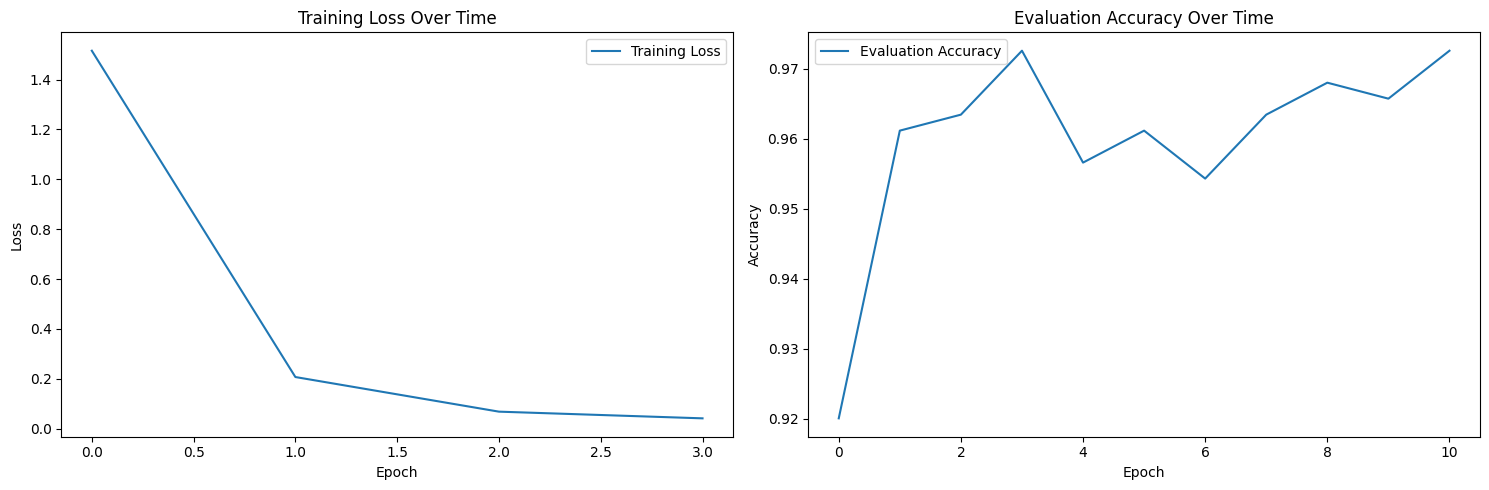

In [13]:
# Visualize Training and Evaluation Metrics

# Load training logs
history = trainer.state.log_history

# Extract data
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss on the first subplot
ax1.plot(train_loss, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Time')
ax1.legend()

# Plot evaluation accuracy on the second subplot
ax2.plot(eval_acc, label='Evaluation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Evaluation Accuracy Over Time')
ax2.legend()

plt.tight_layout()
plt.show()


***** Running Prediction *****
  Num examples = 438
  Batch size = 16


  0%|          | 0/28 [00:00<?, ?it/s]

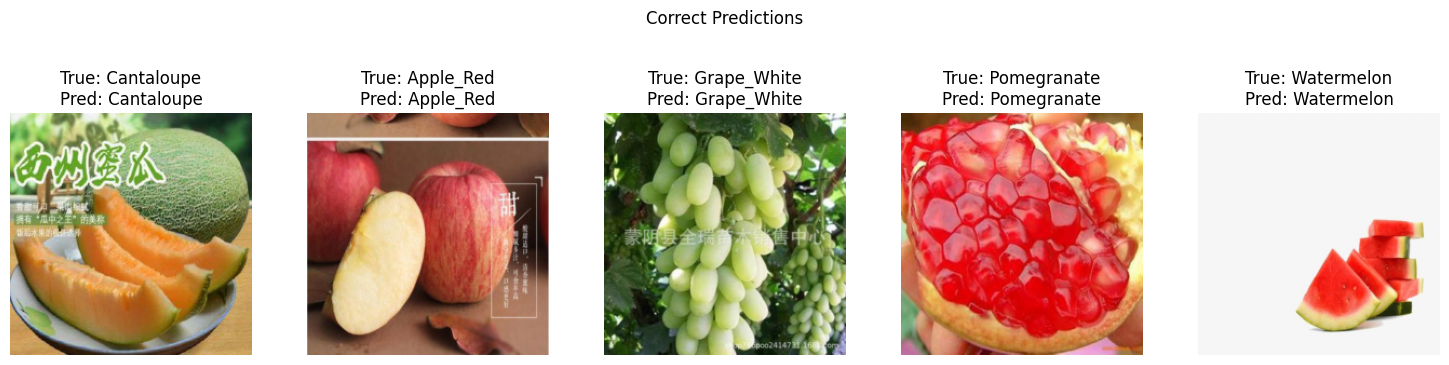

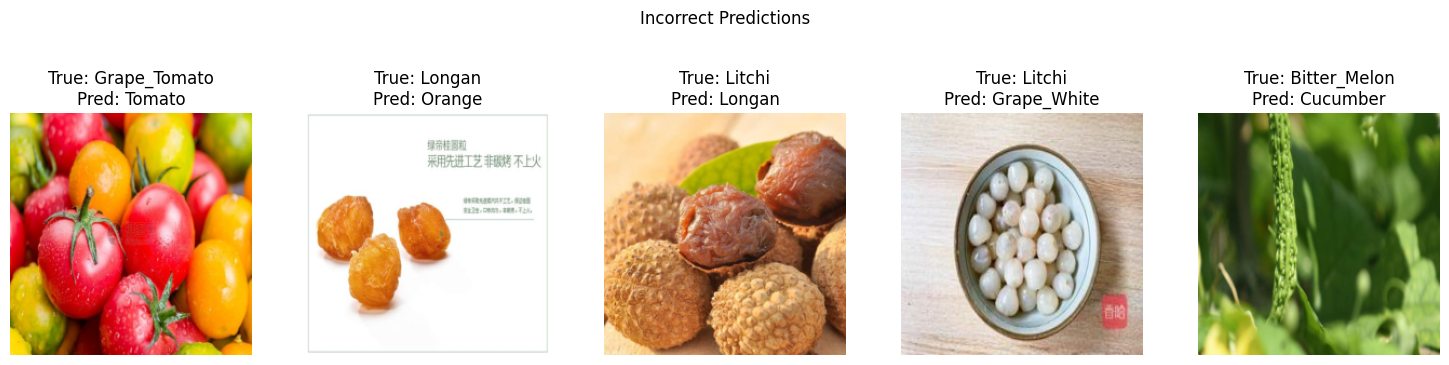

In [14]:
def show_predictions(trainer, dataset, num_images=5):
    # Generate predictions
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Get random sample of correct and incorrect predictions
    correct_indices = np.where(preds == labels)[0]
    incorrect_indices = np.where(preds != labels)[0]

    correct_samples = np.random.choice(correct_indices, num_images, replace=False).tolist()
    incorrect_samples = np.random.choice(incorrect_indices, num_images, replace=False).tolist()

    # Function to show images
    def display_samples(indices, title):
        fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
        for idx, ax in zip(indices, axes):
            idx = int(idx)  # Convert numpy.int64 to Python int
            image = torch.tensor(dataset[idx]['pixel_values'])  # Ensure tensor
            image = image.permute(1, 2, 0).numpy()  # Permute dimensions for display
            label = int(dataset[idx]['label'])
            pred_label = int(preds[idx])
            # Normalize the image to [0, 1] for display
            image = (image - image.min()) / (image.max() - image.min())
            ax.imshow(image)
            ax.set_title(f"True: {dataset.features['label'].int2str(label)}\nPred: {dataset.features['label'].int2str(pred_label)}")
            ax.axis('off')
        plt.tight_layout()
        plt.suptitle(title, y=1.2)
        plt.show()

    # Display correct and incorrect predictions
    display_samples(correct_samples, "Correct Predictions")
    display_samples(incorrect_samples, "Incorrect Predictions")

show_predictions(trainer, dataset['val'])


In [15]:
# Evaluate the model on the test set
test_results = trainer.evaluate(eval_dataset=dataset['test'])
print(f"Test Results: {test_results}")

***** Running Evaluation *****
  Num examples = 1078
  Batch size = 16


Test Results: {'eval_loss': 0.2212006002664566, 'eval_accuracy': 0.9619666048237476, 'eval_runtime': 16.8437, 'eval_samples_per_second': 64.0, 'eval_steps_per_second': 4.037, 'epoch': 10.0}
